In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from prettytable import PrettyTable

## Loading datasets

In [16]:
train = pd.read_csv('UCI_HAR_Dataset/train/train.csv')
test = pd.read_csv('UCI_HAR_Dataset/test/test.csv')

In [17]:
train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING


#### Prepare train dataset

In [18]:
X_train = train.drop(['subject', 'Activity'], axis=1)
y_train = train.Activity

In [19]:
X_test = test.drop(['subject', 'Activity'], axis=1)
y_test = test.Activity

In [20]:
print('X_train and y_train : ({},{})'.format(X_train.shape, y_train.shape))
print('X_test  and y_test  : ({},{})'.format(X_test.shape, y_test.shape))

X_train and y_train : ((7352, 561),(7352,))
X_test  and y_test  : ((2947, 561),(2947,))


### Random Forest  

In [21]:
def find_optimal_random_forest_model(x, y):
    param = {"max_depth": np.arange(3, 10, 2), "n_estimators": np.arange(10, 101, 20)}
    grid_search = GridSearchCV(RandomForestClassifier(), param_grid=param, verbose=1, n_jobs=-1,
                               return_train_score=True)
    grid_search.fit(x, y)
    print("Best HyperParameter: ", grid_search.best_params_)
    print("Best Accuracy: %.2f" % (grid_search.best_score_))
    return grid_search

In [22]:
# function to plot the performance of the model on train data and cross validation data for each hyper parameter
def plot_performance_of_random_forest_model(grid_search):
    df_gridsearch = pd.DataFrame(grid_search.cv_results_)
    max_scores = df_gridsearch.groupby(['param_max_depth','param_n_estimators']).max()
    max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
    print("Accuracy for train data")
    plt.figure(figsize=(10,5))
    sns.heatmap(max_scores.mean_train_score, annot=True, fmt="g", cmap='viridis')
    plt.show()
    print("Accuracy for CV data")
    plt.figure(figsize=(10,5))
    sns.heatmap(max_scores.mean_test_score, annot=True, fmt="g", cmap='viridis')
    plt.show()
    
    # calculate overall accuracty of the model
    accuracy = grid_search.best_score_
    print('---------------------')
    print('|      Accuracy      |')
    print('---------------------')
    print('\n    {}\n\n'.format(accuracy))

In [23]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_cm(grid_search, X_train, y_train, x_test, y_test, cmap=plt.cm.Blues):
    optimal_max_depth = grid_search.best_estimator_.max_depth
    optimal_n_estimators = grid_search.best_estimator_.n_estimators
    rf = RandomForestClassifier(max_depth=optimal_max_depth, n_estimators=optimal_n_estimators)
    rf.fit(X_train, y_train)
    
    class_labels = ['LAYING', 'SITTING','STANDING','WALKING','WALKING_DOWNSTAIRS','WALKING_UPSTAIRS']
    
    prediction = rf.predict(x_test)
    cm = confusion_matrix(prediction, y_test)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots(figsize=(20, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=class_labels,
           yticklabels=class_labels,
           title='Confusion matrix',
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    plt.show()

In [24]:
from sklearn import metrics
def model_conclusions(grid_search, X_train, y_train, X_test, y_test):

    optimal_max_depth = grid_search.best_estimator_.max_depth
    optimal_n_estimators = grid_search.best_estimator_.n_estimators
    rf = RandomForestClassifier(max_depth=optimal_max_depth, n_estimators=optimal_n_estimators)
    rf.fit(X_train, y_train)
    
    class_labels = ['LAYING', 'SITTING','STANDING','WALKING','WALKING_DOWNSTAIRS','WALKING_UPSTAIRS']
    
    prediction = rf.predict(X_test)    
    print('-------------------------')
    print('| Classifiction Report |')
    print('-------------------------')
    classification_report = metrics.classification_report(y_test, prediction)
    print(classification_report)
    
    x = PrettyTable()
    x.field_names = ["Hyperameter(max_depth)", "Hyperameter(n_estimators)", "Accuracy"]
    
    x.add_row([grid_search.best_params_['max_depth'], grid_search.best_params_['n_estimators'],
               grid_search.best_score_])

    print (x)

In [25]:
grid_search = find_optimal_random_forest_model(X_train, y_train)

C:\Users\Master\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.9min finished


Best HyperParameter:  {'max_depth': 7, 'n_estimators': 90}
Best Accuracy: 0.91


Accuracy for train data


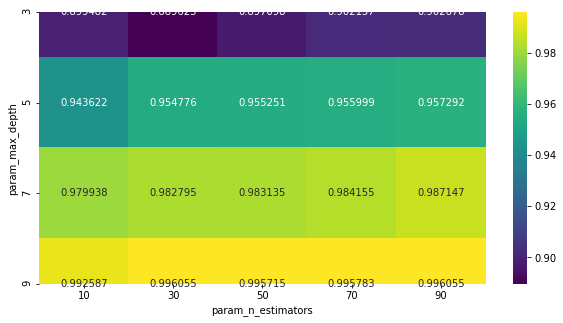

Accuracy for CV data


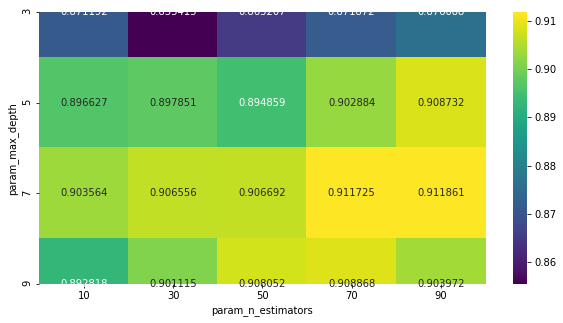

---------------------
|      Accuracy      |
---------------------

    0.911860718171926




In [26]:
plot_performance_of_random_forest_model(grid_search)

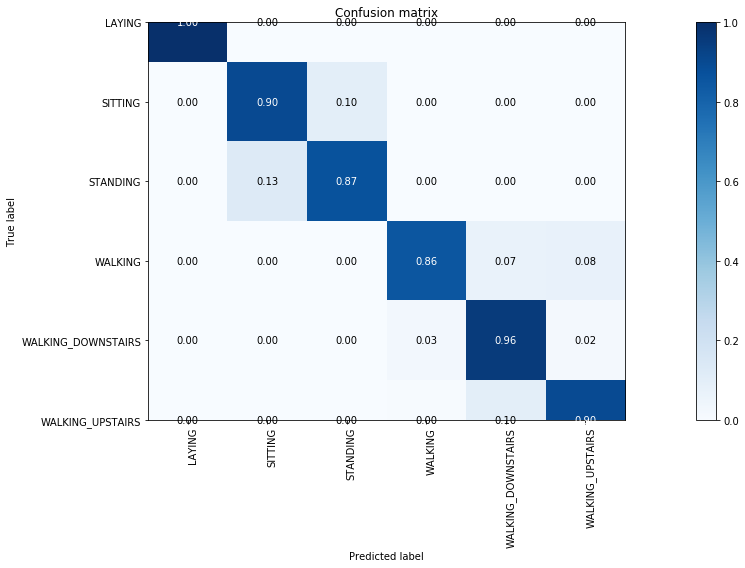

In [27]:
plot_cm(grid_search, X_train, y_train, X_test, y_test)

In [28]:
model_conclusions(grid_search, X_train, y_train, X_test, y_test)

-------------------------
| Classifiction Report |
-------------------------
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.91      0.87      0.89       491
          STANDING       0.88      0.92      0.90       532
           WALKING       0.86      0.98      0.91       496
WALKING_DOWNSTAIRS       0.95      0.80      0.87       420
  WALKING_UPSTAIRS       0.90      0.90      0.90       471

          accuracy                           0.91      2947
         macro avg       0.92      0.91      0.91      2947
      weighted avg       0.92      0.91      0.91      2947

+------------------------+---------------------------+-------------------+
| Hyperameter(max_depth) | Hyperameter(n_estimators) |      Accuracy     |
+------------------------+---------------------------+-------------------+
|           7            |             90            | 0.911860718171926 |
+-------------------

## Observations:

### 1. The accuracy obtained was 91%.

### 2. From confusion matrix, we can tell that we were able to identify "Laying" activity with 100% precision and 100% recall.

### 3. From the confusion matrix, we can tell that there is a confusion between classifying "Sitting" activity with "Standing" activity